In [1]:
import os
import pickle
import numpy as np
import pandas as pd
from IPython.display import display
from matplotlib import pyplot as plt

from liquidity.response_functions import fit
from liquidity.util.utils import bin_data_into_quantiles
from liquidity.util.goodness_of_fit import compute_rsquared
from liquidity.response_functions.features import compute_aggregate_features
from liquidity.response_functions.functional_form import scaling_form, rescaled_form

In [2]:
%load_ext autoreload
%autoreload 2

In [3]:
# Window/bin size
T = 100

In [23]:
# Load raw sample data  from CSV
stocks = ['TSLA', 'AMZN', 'NFLX', 'MSFT', 'EBAY', 'APPL']

current_dir = os.path.abspath('.')
root_dir = os.path.join(current_dir, '..', '..')
data_dir = os.path.join(root_dir, 'data', 'market_orders')

stock_dfs = {}

# Loop through each stock
for stock in stocks:
    filename = f"{stock}-2016-R1.csv"

    stock_file_path = os.path.join(data_dir, filename)

    # Read the CSV and store in the dictionary
    stock_dfs[stock] = pd.read_csv(stock_file_path)

# Access the dataframe using stock's ticker as key
tsla_raw_df = stock_dfs['TSLA']
amzn_raw_df = stock_dfs['AMZN']
nflx_raw_df = stock_dfs['NFLX']
msft_raw_df = stock_dfs['MSFT']
ebay_raw_df = stock_dfs['EBAY']
appl_raw_df = stock_dfs['APPL']

In [24]:
display(appl_raw_df)

,Unnamed: 0,event_timestamp,trade_sign,side,lob_action,order_executed,execution_price,execution_size,ask,bid,midprice,ask_volume,bid_volume,price_changing,midprice_change,R1,norm_trade_volume
0,0,2017-01-03 10:30:19.351489154,1,ASK,UPDATE,True,219.37,1,219.37,219.28,219.325,16.0,100.0,False,0.000,0.000,0.008150
1,1,2017-01-03 10:30:19.351537884,1,ASK,REMOVE,True,219.37,15,219.37,219.28,219.325,15.0,100.0,True,0.005,0.005,0.122257
2,2,2017-01-03 10:30:19.351549791,1,ASK,UPDATE,True,219.38,80,219.38,219.28,219.330,200.0,100.0,False,0.005,0.005,0.652035
3,3,2017-01-03 10:30:19.351601187,1,ASK,UPDATE,True,219.38,80,219.38,219.29,219.335,120.0,100.0,False,0.000,0.000,0.652035
4,4,2017-01-03 10:30:19.351702603,1,ASK,REMOVE,True,219.38,40,219.38,219.29,219.335,40.0,100.0,True,0.050,0.050,0.326018
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1411991,1411991,2017-12-29 14:59:11.533706465,1,ASK,REMOVE,True,311.06,321,311.06,311.02,311.040,321.0,125.0,True,0.025,0.025,1.774181
1411992,1411992,2017-12-29 14:59:50.386983509,-1,BID,REMOVE,True,311.03,200,311.10,311.03,311.065,3400.0,200.0,True,-0.030,0.030,0.881088
1411993,1411993,2017-12-29 14:59:50.387892067,-1,BID,UPDATE,True,311.02,200,311.05,311.02,311.035,10.0,220.0,False,0.000,-0.000,0.881088
1411994,1411994,2017-12-29 14:59:50.387904347,-1,BID,UPDATE,True,311.02,2,311.05,311.02,311.035,10.0,20.0,False,0.000,-0.000,0.008811


## Finding scaling parameters

Scaling function – $\mathscr{F}(x) = \frac{x}{(1 + |x|^\alpha)^{\frac{\beta}{\alpha}}}$
Scaling form –  $R(ΔV,T) \approx R(1) \times T^{\chi} \times  \mathscr{F}\left(\frac{ΔV}{T^{\kappa}}\right)$
Rescaled form – $R(ΔV) \approx R_T \times  \mathscr{F}\left(\frac{ΔV}{\mathcal{E}_T}\right)$

In order to map out the scale factors  $R_T$ and $\mathcal{E}_T$ we use the following approach:

Part $I$:

   – Fit scaling form on all $T$ in the data to determine a heuristic guess of the scaling parameters $\alpha$, $\beta$,  $\chi$ and $\kappa$.

   – Use found shape parameters $\alpha$ and $\beta$ and scaling exponents $\chi$ and $\kappa$ to approximate an initial renormalization of data.

Part $II$:

   – Once the found parameters $\alpha$ and $\beta$ of $\mathscr{F}(x)$ are fixed, we use them to map out scale factors $R_T$ and $\mathcal{E}_T$ by
     fitting the rescaled form $R(ΔV)$  as a funtion of $T$, which are accurately described by a power law $R_T \sim T^\chi$ and $\mathcal{E}_T \sim T^\kappa$.

   – Use the mapped out scale factors to extract the fitted scaling exponents and perform a renomalization of the data to obtain the final master curves.

## 1. Part $I$: Fit scaling form $R(ΔV,T)$ on normalised data

In [25]:
FITTING_LAGS = [10, 20, 50, 100, 150]

In [26]:
norm_agg_features_df = compute_aggregate_features(appl_raw_df, FITTING_LAGS)

In [27]:
norm_fit_result_dict = {}
for lag in FITTING_LAGS:
    data = norm_agg_features_df[norm_agg_features_df['T']==lag][["vol_imbalance", "T", "R"]]
    data_binned = bin_data_into_quantiles(data, q=31)

    norm_fit_result_dict[lag] = fit.fit_scaling_form(data_binned)

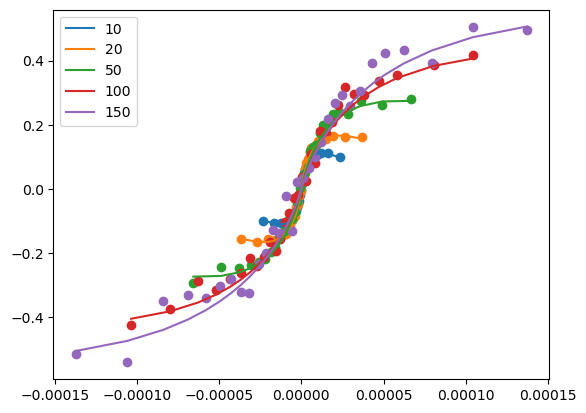

In [28]:
residual_dict = {}
for lag, fit_result in norm_fit_result_dict.items():
    # plt.figure(figsize=(4, 4))
    param = fit_result[0]
    data = norm_agg_features_df[norm_agg_features_df['T']==lag][["vol_imbalance", "T", "R"]]
    data_binned = bin_data_into_quantiles(data, q=31)
    xs = data_binned["vol_imbalance"].values
    ys = data_binned["R"].values
    imbalance_T = np.transpose(data_binned.iloc[:, :2].to_numpy())
    y_hat = scaling_form(imbalance_T, *param)
    residuals = ys - y_hat
    residual_dict[lag] = residuals, ys

    plt.scatter(xs, ys)
    plt.plot(imbalance_T[0], y_hat, label=f"{lag}")
    plt.legend()

In [29]:
from sklearn.metrics import mean_squared_error
from scipy.stats import ks_2samp
for lag in residual_dict.keys():
    fit_result = norm_fit_result_dict[lag]
    param = fit_result[0]

    r2, ar2 = compute_rsquared(*residual_dict[lag], param)
    mse = mean_squared_error(ys, y_hat)
    ks_distance = ks_2samp(ys, y_hat, alternative="two-sided")
    print(f"For T={lag} \n R2 = {r2}, \n Adj R2 = {ar2}, \n ks_distance = {ks_distance} \n \n")

For T=10 
 R2 = 0.9977083386920073, 
 Adj R2 = 0.9972500064304087, 
 ks_distance = KstestResult(statistic=0.12903225806451613, pvalue=0.9634297148886908, statistic_location=-0.3519384530954189, statistic_sign=-1) 
 

For T=20 
 R2 = 0.9963951457633112, 
 Adj R2 = 0.9956741749159734, 
 ks_distance = KstestResult(statistic=0.12903225806451613, pvalue=0.9634297148886908, statistic_location=-0.3519384530954189, statistic_sign=-1) 
 

For T=50 
 R2 = 0.9929644274269085, 
 Adj R2 = 0.9915573129122902, 
 ks_distance = KstestResult(statistic=0.12903225806451613, pvalue=0.9634297148886908, statistic_location=-0.3519384530954189, statistic_sign=-1) 
 

For T=100 
 R2 = 0.9857183691241517, 
 Adj R2 = 0.982862042948982, 
 ks_distance = KstestResult(statistic=0.12903225806451613, pvalue=0.9634297148886908, statistic_location=-0.3519384530954189, statistic_sign=-1) 
 

For T=150 
 R2 = 0.9771940080671632, 
 Adj R2 = 0.9726328096805958, 
 ks_distance = KstestResult(statistic=0.12903225806451613, pval

# Fit scaling form on renormalised data

In [10]:
MO_LAG_INTERVALS = list(range(1, T))

In [32]:
# popt_ebay, pcov_ebay, fit_func_ebay, data_norm_ebay = compute_shape_parameters(ebay_raw_df, MO_LAG_INTERVALS)
# popt_msft, pcov_msft, fit_func_msft, data_norm_msft = compute_shape_parameters(msft_raw_df, MO_LAG_INTERVALS)
popt_appl, pcov_appl, fit_func_appl, data_norm_appl = fit.compute_shape_parameters(appl_raw_df, MO_LAG_INTERVALS)
# popt_nflx, pcov_nflx, fit_func_nflx, data_norm_nflx = compute_shape_parameters(nflx_raw_df, MO_LAG_INTERVALS)
# popt_amzn, pcov_amzn, fit_func_amzn, data_norm_amzn = compute_shape_parameters(amzn_raw_df, MO_LAG_INTERVALS)

## TESTING

In [4]:
current_dir = os.path.abspath('.')
root_dir = os.path.join(current_dir, '..', '..')
data_dir = os.path.join(root_dir, 'data', 'market_orders')
filename = "APPL-2016-R1.csv"
stock_file_path = os.path.join(data_dir, filename)
appl_data_raw = pd.read_csv(stock_file_path)

In [13]:
FITTING_LAGS = MO_LAG_INTERVALS

In [14]:
# remove outlier (default)
popt_appl1, pcov_appl1, fit_func_appl1, data_norm_appl1 = fit.compute_shape_parameters(appl_data_raw, FITTING_LAGS)
display(popt_appl1)

array([5.27391182e-01, 8.28367457e-01, 5.94433916e-01, 2.43251108e+03,
       8.90415317e+04])

In [18]:
chi, kappa, alpha, beta, gamma = popt_appl1
params1 = {
    'chi': chi,
    'kappa': kappa,
    'alpha': alpha,
    'beta': beta,
    'gamma': gamma
}
params1

{'chi': 0.5273911823169363,
 'kappa': 0.8283674572095264,
 'alpha': 0.5944339164231282,
 'beta': 2432.5110798488367,
 'gamma': 89041.53165906374}

In [15]:
# NOT remove outlier
popt_appl2, pcov_appl2, fit_func_appl2, data_norm_appl2 = fit.compute_shape_parameters(appl_data_raw, FITTING_LAGS, remove_outliers=False)
display(popt_appl2)

array([5.30399797e-01, 8.33751680e-01, 4.58682267e-01, 3.68287653e+02,
       1.18675987e+05])

In [19]:
chi, kappa, alpha, beta, gamma = popt_appl2
params2 = {
    'chi': chi,
    'kappa': kappa,
    'alpha': alpha,
    'beta': beta,
    'gamma': gamma
}
params2

{'chi': 0.530399796600703,
 'kappa': 0.8337516797675467,
 'alpha': 0.4586822673363147,
 'beta': 368.2876534177346,
 'gamma': 118675.98724990043}

In [16]:
# run again
popt_appl3, pcov_appl3, fit_func_appl3, data_norm_appl3 = fit.compute_shape_parameters(appl_data_raw, FITTING_LAGS)
display(popt_appl3)

array([5.27391182e-01, 8.28367457e-01, 5.94433916e-01, 2.43251108e+03,
       8.90415317e+04])

In [20]:
chi, kappa, alpha, beta, gamma = popt_appl3
params3 = {
    'chi': chi,
    'kappa': kappa,
    'alpha': alpha,
    'beta': beta,
    'gamma': gamma
}
params3

{'chi': 0.5273911823169363,
 'kappa': 0.8283674572095264,
 'alpha': 0.5944339164231282,
 'beta': 2432.5110798488367,
 'gamma': 89041.53165906374}

In [17]:
# NOT normalise
popt_appl4, pcov_appl4, fit_func_appl4, data_norm_appl4 = fit.compute_shape_parameters(appl_data_raw, FITTING_LAGS, normalise=False)
display(popt_appl4)

array([0.69518319, 1.04282756, 1.55973373, 3.35352819, 0.0836362 ])

In [21]:
chi, kappa, alpha, beta, gamma = popt_appl4
params4 = {
    'chi': chi,
    'kappa': kappa,
    'alpha': alpha,
    'beta': beta,
    'gamma': gamma
}
params4

{'chi': 0.6951831946346549,
 'kappa': 1.0428275604170847,
 'alpha': 1.5597337345446072,
 'beta': 3.353528187003223,
 'gamma': 0.08363619923433775}

## TESTING

In [30]:
result_all = {
#     'TSLA': (popt_tsla, pcov_tsla, fit_func, data_norm),
#     'EBAY': (popt_ebay, pcov_ebay, fit_func_ebay, data_norm_ebay),
#     'MSFT': (popt_msft, pcov_msft, fit_func_msft, data_norm_msft),
    'APPL': (popt_appl, pcov_appl, fit_func_appl, data_norm_appl),
#     'NFLX': (popt_nflx, pcov_nflx, fit_func_nflx, data_norm_nflx),
#     'AMZN': (popt_amzn, pcov_amzn, fit_func_amzn, data_norm_amzn)
}

In [31]:
import pickle
#pickle.dump(result_all, open('../../data/generated/shape_parameters_mo.pkl', 'wb'))
shape_params_dict = pickle.load(open('../../data/generated/shape_parameters_mo.pkl', 'rb'))
shape_params_dict.keys()

dict_keys(['APPL'])

### Parameters of master curve

In [32]:
appl_shape_params = shape_params_dict['APPL']

In [33]:
popt_appl, pcov_appl, fit_func_appl, data_norm_appl = appl_shape_params

In [34]:
chi, kappa, alpha, beta, gamma = popt_appl

In [35]:
chi

0.5273911823169363

In [36]:
kappa

0.8283674572095264

In [37]:
alpha

0.5944339164231282

In [38]:
beta

2432.5110798488367

In [39]:
param = shape_params_dict['APPL']

In [40]:
COLLAPSE_LAGS = [10, 20, 50, 100, 150]

In [41]:
norm_agg_features_df_for_durations = norm_agg_features_df[norm_agg_features_df['T'].isin(COLLAPSE_LAGS)]

### Compare fits of individual curves to the renormalised data

In [42]:
"""
* fit scaling form on all renormalised data
"""

'\n* fit scaling form on all renormalised data\n'

In [43]:
renomalized_param_dict = fit.renormalise(norm_agg_features_df_for_durations, popt_appl, durations=COLLAPSE_LAGS)

/Users/ana_bugaenko/workspace/another_workspace/liquidity/liquidity/response_functions/functional_form.py:31: RuntimeWarning: overflow encountered in power
  return x / np.power(1 + np.power(abs(x), alpha), beta / alpha)
/Users/ana_bugaenko/workspace/another_workspace/liquidity/liquidity/response_functions/functional_form.py:31: RuntimeWarning: overflow encountered in power
  return x / np.power(1 + np.power(abs(x), alpha), beta / alpha)


In [44]:
for k,v in renomalized_param_dict.items():
    mape = v.params[1]
    print(f"for lag {k} mape is {mape}")

for lag 10 mape is [[ 1.35261601e+12 -5.46992311e+07  2.35905803e+04 -1.02773404e+11
  -7.48646623e+12]
 [-5.46992311e+07  2.93889937e+05 -1.09878653e+02  5.52468231e+08
   3.04364202e+08]
 [ 2.35905803e+04 -1.09878653e+02  4.29860729e-02 -2.06516914e+05
  -1.31172242e+05]
 [-1.02773404e+11  5.52468231e+08 -2.06516914e+05  1.03855673e+12
   5.71866008e+11]
 [-7.48646623e+12  3.04364202e+08 -1.31172242e+05  5.71866008e+11
   4.14361419e+13]]
for lag 20 mape is [[ 1.75873368e+12  1.08955993e+08 -4.05302310e+04  3.42401367e+11
  -8.87908207e+12]
 [ 1.08955993e+08  3.85099801e+05 -1.56878280e+02  1.20983340e+09
  -5.48160947e+08]
 [-4.05302310e+04 -1.56878280e+02  6.78157393e-02 -4.92752478e+05
   2.03840017e+05]
 [ 3.42401367e+11  1.20983340e+09 -4.92752478e+05  3.80082719e+12
  -1.72263366e+12]
 [-8.87908207e+12 -5.48160947e+08  2.03840017e+05 -1.72263366e+12
   4.48266364e+13]]
for lag 50 mape is [[ 7.37118260e+11 -1.03268272e+08  6.50347296e+04 -1.96148854e+11
  -2.95259777e+12]
 [-1.0

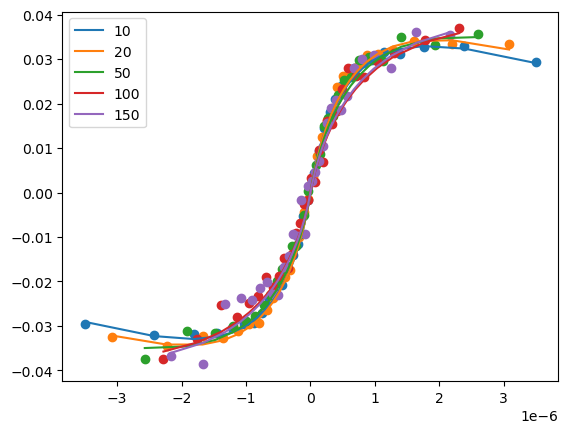

In [45]:
residual_dict = {}
for lag, fit_result in renomalized_param_dict.items():
    # plt.figure(figsize=(4, 4))
    param = fit_result.params[0]
    data = fit_result.data
    data_binned = bin_data_into_quantiles(data, q=31)
    xs = data_binned["vol_imbalance"].values
    ys = data_binned["R"].values
    imbalance_T = np.transpose(data_binned.iloc[:, :2].to_numpy())
    y_hat = scaling_form(imbalance_T, *param)
    residuals = ys - y_hat
    residual_dict[lag] = residuals, ys

    plt.scatter(xs, ys)
    plt.plot(imbalance_T[0], y_hat, label=f"{lag}")
    plt.legend()

In [46]:
for lag in renomalized_param_dict.keys():
    fit_result = renomalized_param_dict[lag]
    param = fit_result.params[0]

    r2, ar2 = compute_rsquared(*residual_dict[lag], param)
    print(f"For T={lag} \n R2 = {r2}, \n Adj R2 = {ar2} \n \n,")

For T=10 
 R2 = 0.9977076595676029, 
 Adj R2 = 0.9972491914811235 
 
,
For T=20 
 R2 = 0.9963938876701763, 
 Adj R2 = 0.9956726652042116 
 
,
For T=50 
 R2 = 0.9929590287195801, 
 Adj R2 = 0.9915508344634961 
 
,
For T=100 
 R2 = 0.9857136368443721, 
 Adj R2 = 0.9828563642132465 
 
,
For T=150 
 R2 = 0.9771902429900517, 
 Adj R2 = 0.9726282915880621 
 
,


### Compare master curve fit to the renormalised data

In [47]:
"""
plot data points for larger lags
"""

'\nplot data points for larger lags\n'

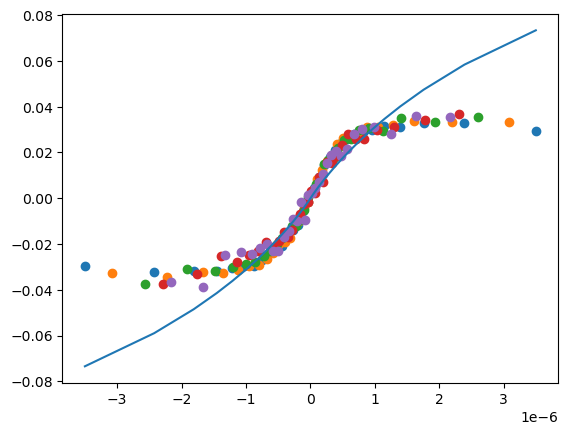

In [48]:
residual_dict = {}
for lag, fit_result in renomalized_param_dict.items():
    # plt.figure(figsize=(4, 4))
    param = shape_params_dict['APPL'][0]

    data = fit_result.data
    data_binned = bin_data_into_quantiles(data, q=31)
    xs = data_binned["vol_imbalance"].values
    ys = data_binned["R"].values
    imbalance_T = np.transpose(data_binned.iloc[:, :2].to_numpy())
    y_hat = scaling_form(imbalance_T, *param)
    residuals = ys - y_hat
    residual_dict[lag] = residuals, ys

    plt.scatter(xs, ys)
    if lag == 10:
        plt.plot(imbalance_T[0], y_hat)

In [49]:
for lag in renomalized_param_dict.keys():
    fit_result = renomalized_param_dict[lag]
    param = fit_result.params[0]

    r2, ar2 = compute_rsquared(*residual_dict[lag], param)
    print(f"For T={lag} \n R2 = {r2}, \n Adj R2 = {ar2} \n \n,")

For T=10 
 R2 = 0.6728346227992437, 
 Adj R2 = 0.6074015473590924 
 
,
For T=20 
 R2 = 0.7833565777623333, 
 Adj R2 = 0.7400278933147999 
 
,
For T=50 
 R2 = 0.8769260329028122, 
 Adj R2 = 0.8523112394833747 
 
,
For T=100 
 R2 = 0.8880589700083186, 
 Adj R2 = 0.8656707640099823 
 
,
For T=150 
 R2 = 0.8415976688257157, 
 Adj R2 = 0.8099172025908589 
 
,


## 1.2. After Collapse

In [50]:
"""
Lage beta:

- fix 1: restraint volume imbalance scope when fitting (requires re-running fit of scaling form for each N each stock

- temp fix 2: remove outliers in the series of RN and QN

"""

'\nLage beta:\n\n- fix 1: restraint volume imbalance scope when fitting (requires re-running fit of scaling form for each N each stock\n\n- temp fix 2: remove outliers in the series of RN and QN\n\n'

## 2. Fitting Rescaled Form on normalised data

    - Find RN, QN, given Alpha, Beta

Approach II: produce series of RN and QN by fitting scaling funtion for different N, then use powerlaw library to fit power law and determine scale factors; finally, fit known scaling form to find exponents and then use them for renormalisation.

In [63]:
LAGS = list(range(1, 1001))

In [52]:
# # Aggregate orderflow
# tsla_imbalance = get_agg_features(tsla_raw_df, LAGS, remove_outliers=False)
# pickle.dump(tsla_imbalance, open('../../data/generated/tsla_aggregate_features_mo_df.pkl', 'wb'))

In [ ]:
# msft_imbalance = get_agg_features(msft_raw_df, LAGS, remove_outliers=False)
# pickle.dump(msft_imbalance, open('../../data/generated/msft_aggregate_features_mo_df.pkl', 'wb'))

In [ ]:
# amzn_imbalance= get_agg_features(amzn_raw_df, LAGS, remove_outliers=False)
# pickle.dump(amzn_imbalance, open('../../data/generated/amzn_aggregate_features_mo_df.pkl', 'wb'))

In [ ]:
# nflx_imbalance = get_agg_features(nflx_raw_df, LAGS,remove_outliers=False)
# pickle.dump(nflx_imbalance, open('../../data/generated/nflx_aggregate_features_mo_df.pkl', 'wb'))

In [ ]:
# ebay_imbalance = get_agg_features(ebay_raw_df, LAGS, remove_outliers=False)
# pickle.dump(ebay_imbalance, open('../../data/generated/ebay_aggregate_features_mo_df.pkl', 'wb'))

In [64]:
appl_imbalance = compute_aggregate_features(appl_raw_df, LAGS,remove_outliers=False)
pickle.dump(appl_imbalance, open('../../data/generated/appl_aggregate_features_mo_df.pkl', 'wb'))

### Load pre-computed data

In [65]:
appl_features_df = pickle.load(open('../../data/generated/appl_aggregate_features_mo_df.pkl', 'rb'))

In [66]:
display(appl_features_df.head())

,event_timestamp,midprice,sign,signed_volume,vol_imbalance,sign_imbalance,daily_R1,daily_vol,daily_num,R,T
0,2017-01-03 10:30:19.351489154,219.325,1,0.008150,2.934072e-08,0.000305,0.021159,277786,3279,0.000,1
1,2017-01-03 10:30:19.351537884,219.325,1,0.122257,4.401108e-07,0.000305,0.021159,277786,3279,0.005,1
2,2017-01-03 10:30:19.351549791,219.330,1,0.652035,2.347257e-06,0.000305,0.021159,277786,3279,0.005,1
3,2017-01-03 10:30:19.351601187,219.335,1,0.652035,2.347257e-06,0.000305,0.021159,277786,3279,0.000,1
4,2017-01-03 10:30:19.351702603,219.335,1,0.326018,1.173629e-06,0.000305,0.021159,277786,3279,0.050,1


### Generate series of RN and QN by fitting scaling form with known parameters of alpha and beta

In [67]:
from liquidity.response_functions.fit import compute_RN_QN

In [68]:
# fit powerlaw on series of RN and QN ranges
RN_df, QN_df, RN_fit_object, QN_fit_object = compute_RN_QN(appl_features_df, alpha, beta)

/Users/ana_bugaenko/workspace/another_workspace/liquidity/liquidity/response_functions/functional_form.py:31: RuntimeWarning: overflow encountered in power
  return x / np.power(1 + np.power(abs(x), alpha), beta / alpha)
/Users/ana_bugaenko/workspace/another_workspace/liquidity/liquidity/response_functions/functional_form.py:31: RuntimeWarning: overflow encountered in power
  return x / np.power(1 + np.power(abs(x), alpha), beta / alpha)
/Users/ana_bugaenko/workspace/another_workspace/liquidity/liquidity/response_functions/functional_form.py:31: RuntimeWarning: overflow encountered in power
  return x / np.power(1 + np.power(abs(x), alpha), beta / alpha)
/Users/ana_bugaenko/workspace/another_workspace/liquidity/liquidity/response_functions/functional_form.py:31: RuntimeWarning: overflow encountered in power
  return x / np.power(1 + np.power(abs(x), alpha), beta / alpha)
/Users/ana_bugaenko/workspace/another_workspace/liquidity/liquidity/response_functions/functional_form.py:31: Runtim

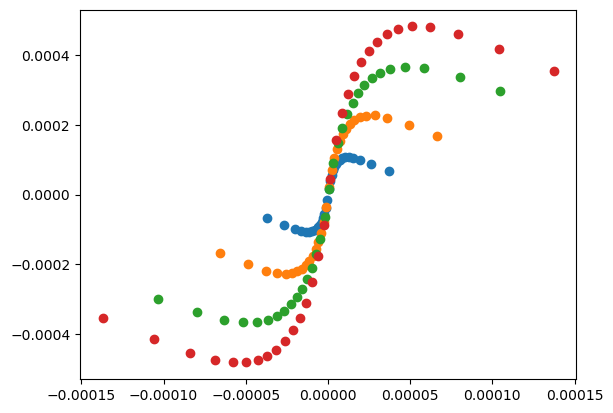

In [69]:
PLOTTING_LAGS = [10, 20, 50, 100, 150]
PLOTTING_LAGS = [x for x in PLOTTING_LAGS if x in RN_df['x_values'].values]

rn = RN_df[RN_df['x_values'].isin(PLOTTING_LAGS)]['y_values']
qn = QN_df[QN_df['x_values'].isin(PLOTTING_LAGS)]['y_values']

for lag in PLOTTING_LAGS:
    data = norm_agg_features_df[norm_agg_features_df['T']==lag][["vol_imbalance", "T", "R"]]
    data_binned = bin_data_into_quantiles(data, q=31)
    imbalance = data_binned["vol_imbalance"].values
    indx = PLOTTING_LAGS.index(lag)
    response = rescaled_form(imbalance, rn.iloc[indx], qn.iloc[indx], alpha, beta)
    plt.scatter(imbalance, response)

[]

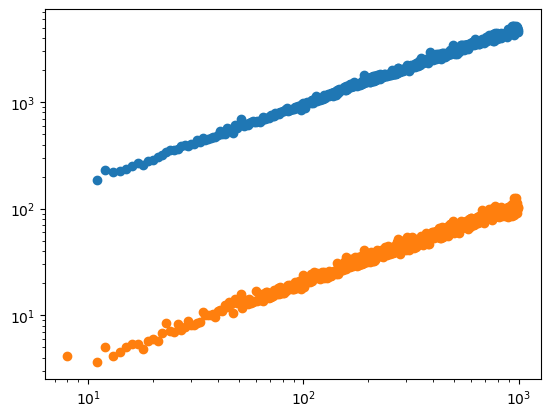

In [70]:
plt.scatter(RN_df['x_values'],RN_df['y_values'])
plt.scatter(QN_df['x_values'],QN_df['y_values'])
plt.loglog()

In [71]:
RN_fit_object.powerlaw.fit_results()


For powerlaw fitted using MLE:

Pre-fitting parameters;
xmin_index: 10
xmin: 21.0

Fitting parameters;
param_names = ['C', 'alpha']
C = 37.36930348034457
alpha = 0.7065692107536967

Goodness of fit to data;
D = 0.030612244897959183
bic = 4612.974338901818
mape = 3.009930628302147
Adjusted R-squared = 0.991749848179239




In [72]:
QN_fit_object.powerlaw.fit_results()


For powerlaw fitted using MLE:

Pre-fitting parameters;
xmin_index: 10
xmin: 20.0

Fitting parameters;
param_names = ['C', 'alpha']
C = 0.8358135204258468
alpha = 0.7032138177149717

Goodness of fit to data;
D = 0.024439918533604887
bic = 1505.0723329023963
mape = 6.794227065643957
Adjusted R-squared = 0.970691201369388




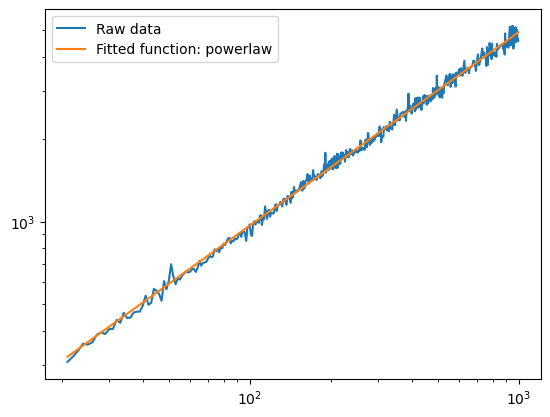

In [73]:
RN_fit_object.powerlaw.plot_fit()

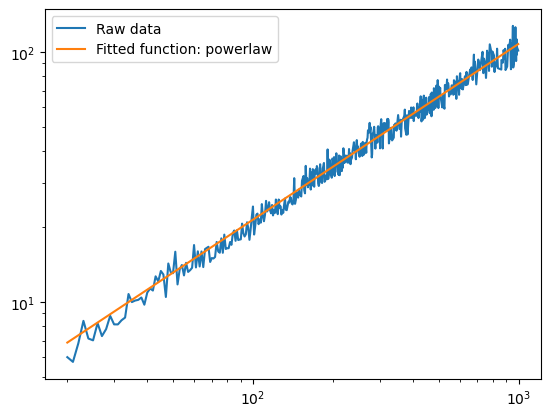

In [74]:
QN_fit_object.powerlaw.plot_fit()

In [75]:
chi = RN_fit_object.powerlaw.params.alpha
kappa = QN_fit_object.powerlaw.params.alpha

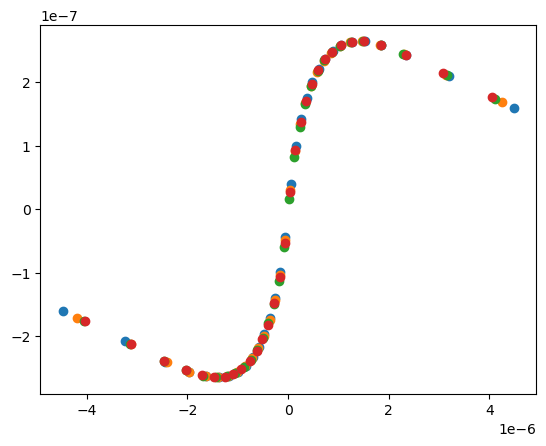

In [78]:
PLOTTING_LAGS = [10, 20, 50, 100, 150]
PLOTTING_LAGS = [x for x in PLOTTING_LAGS if x in RN_df['x_values'].values]

rn = RN_df[RN_df['x_values'].isin(PLOTTING_LAGS)]['y_values']
qn = QN_df[QN_df['x_values'].isin(PLOTTING_LAGS)]['y_values']

for T in PLOTTING_LAGS:
    data = norm_agg_features_df[norm_agg_features_df['T']==T][["vol_imbalance", "T", "R"]]

    data["vol_imbalance"] = data["vol_imbalance"] / T**kappa
    data["R"] = data["R"] / T**chi

    data_binned = bin_data_into_quantiles(data, q=31)
    imbalance = data_binned["vol_imbalance"].values
    indx = PLOTTING_LAGS.index(T)
    response = rescaled_form(imbalance, chi, kappa, alpha, beta)
    plt.scatter(imbalance, response)